In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from abc import ABC, abstractmethod

# Model fitting and Pavlovian biases. Pavlovian-instrumental interactions

Download the dataset .csv from Slack. It contains the data of 10 subjects (see column "ID" for the subject identifier), performing a go/no-go task, each for 600 trials. The column "cue" informs you about the presented trial type (see the "cue mapping" variable in our template). The column "pressed" contains the response of the participant (0 is no-go, 1 is go) and "outcome" contains whether a reward was delivered (1), nothing was delivered (0), a punishment was given (-1).

## Part 1

Recreate figure 2E of the paper "Go and no-go learning in reward and punishment: Interactions between affect and effect" with the data you have. Only the bar plots are important here, no need for error bars or significance tests.

In [87]:
data = pd.read_csv("gen_data.csv")

# Go+ = Go to win
# Go- = go to avoid losing
# NoGo+ = don't go to win
# NoGo- = don't go to avoid losing
cue_mapping = { 1: "Go+", 2: "Go-", 3: "NoGo+", 4: "NoGo-" }

data["CueFactor"] = [cue_mapping.get(cue) for cue in data.cue]
data["CueFactor"] = data["CueFactor"].astype("category")

In [88]:
# Determine if each trial is correct or not
data["Correct"] = False
for i, trial in data.iterrows():
    if trial.CueFactor == "Go+" or trial.CueFactor == "Go-":
        data.loc[i, "Correct"] = trial.pressed == 1

    if trial.CueFactor == "NoGo+" or trial.CueFactor == "NoGo-":
        data.loc[i, "Correct"] = trial.pressed != 1

# Compute the average of correct values for each cue
cue_means = data.groupby(["ID", "CueFactor"], observed = False)["Correct"].mean()

In [89]:
means = []
cues = []
for cue in data.CueFactor.unique():
    cue_data = cue_means.xs(cue, level = "CueFactor")
    means.append(np.mean(cue_data))
    cues.append(cue)

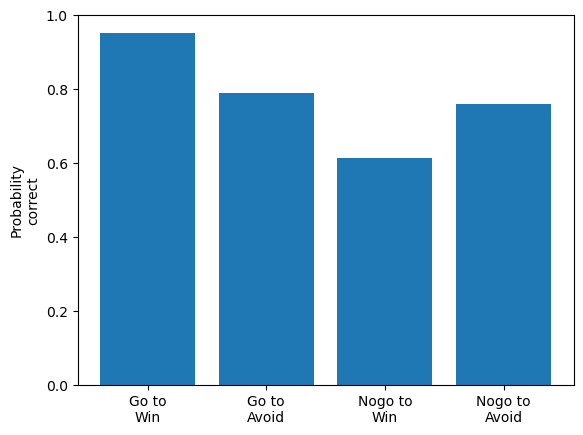

In [90]:
plt.bar(cues, means)
plt.ylabel("Probability\ncorrect")
plt.ylim(0, 1)
plt.xticks(
    ticks = cues,
    labels = [
        "Go to\nWin",
        "Go to\nAvoid",
        "Nogo to\nWin",
        "Nogo to\nAvoid"
    ]
)
plt.show()

## Part 2

Program the log likelihood functions of the models 1 to 7 (including) presented in "Disentangling the Roles of Approach, Activation and Valence in Instrumental and Pavlovian Responding" (see Table 2 of that paper for the model numbering and relevant parameters). The paper uses these parameters

- learning rate $\epsilon$
- feedback sensitivity $\beta$
– the general feedback sensitivity $\beta$ can be replaced by separate reward and punishment sensitivities $\rho$ (we don’t include a sensitivity for omission)
- there can be different learning rates $\epsilon$ for reward, feedback omission, and punishment (the paper doesn't make use of omissions, so they use only two learning rates, you will need three)
- there can be a general bias to approach $bias_{app}$, and a general bias to withhold responding $bias_{wth}$


### General model

$s^{\mathcal{I}}_t$ - the instrumental stimulus, presented at trial $t$ (one out of four: Go+, Go-, NoGo+, and NoGo-).

$a_t$ - the action (choice) at trial $t$. The action can be either go (1) or no-go (0).

$r_t$ - the reinforcement obtained, $r_t \in \{-1, 0, 1\}$ where $-1$ marks a punishment, $0$ marks no reinforcement (feedback omission), and $-1$ marks a reward.

The probability of action $a_t$ in the presence of stimulus $s^{\mathcal{I}}_t$ is a standard probabilistic function:

$$
p(a_t | $s^{\mathcal{I}}_t$) = \frac{exp(\mathcal{W}^{\mathcal{I}} ($s^{\mathcal{I}}_t$, a_t))}{\sum_{a'} exp(\mathcal{W}^{\mathcal{I}} ($s^{\mathcal{I}}_t$, a'))}
$$

Here, $\mathcal{W}^{\mathcal{I}}$ is the instrumental weight of action $a_t$:

$$
\mathcal{W}^{\mathcal{I}}(s^{\mathcal{I}}_t, a_t) = \mathcal{Q}(s^{\mathcal{I}}_t, a_t) + b(a_t)
$$

The variable $b(a_t)$ can take on value $bias_{wth}$ for withhold actions, or $bias_{app}$ for approach actions.

The Q-values are updated according to a Rescorla-Wagner-like rule with a fixed learning rate $\epsilon$. The immediate, intrinsic, value of the reinforcements may have a different meaning for different subjects. To measure this effect, two further parameters are added: $\rho_{rew}$ for the reward sensitivity and $\rho_{pun}$ for the punishment sensitivity. Update equation for the expectations is thus:

$$
\mathcal{Q}_{t+1}(s^{\mathcal{I}}_t, a_t) = \mathcal{Q}_{t}(s^{\mathcal{I}}_t, a_t) + \epsilon (\mathcal{R}_t - \mathcal{Q}_{t}(s^{\mathcal{I}}_t, a_t))
$$

$$
\mathcal{R}_t =\begin{cases}
      \rho_{rew} & \text{ if }\ r_t > 0 \\
      \rho_{pun} & \text{ if }\ r_t < 0 \\
    \end{cases}
$$


In [21]:
class Model(ABC):
    def __init__(self):
        # Init model fit bounds
        self.epsilon_bounds = (0.0000001, 0.99999)
        self.beta_bounds = (0.0001, 9.9999)
        self.bias_bounds = (-0.99999, 0.99999)
        self.p_bounds = (0.0001, 0.9999)
    
    @staticmethod
    def softmax(x):
        exp = np.exp(x)
        return exp / np.sum(exp)

    @staticmethod
    def rescorla_wagner(q_val, epsilon_rew, epsilon_pun, epsilon_omi, reward):
        if reward > 0: return q_val + epsilon_rew * (reward - q_val)
        if reward < 0: return q_val + epsilon_pun * (reward - q_val)
        return q_val + epsilon_omi * (reward - q_val)

    @staticmethod
    def reward(r_t, rho_rew, rho_pun):
        if r_t > 0: return rho_rew
        if r_t < 0: return rho_pun
        return 0

    def log_likelihood(self, cues, actions, rewards, epsilon_rew, epsilon_pun, epsilon_omi, rho_rew, rho_pun, bias_wth, bias_app):
        n_stimuli = len(set(cues))
        n_actions = len(set(actions))
    
        q_vals = np.zeros((n_stimuli, n_actions))
    
        log_likelihood = 0
    
        for t, a_t in enumerate(actions):
            s_t = cues[t] - 1
            r_t = self.reward(rewards[t], rho_rew, rho_pun)

            qs = q_vals[s_t] + [ bias_wth, bias_app ]
    
            probs = self.softmax(qs)
            log_likelihood += np.log(probs[a_t])
    
            # Update the Q-values using Rescorla-Wagner
            q_vals[s_t, a_t] = self.rescorla_wagner(
                q_val = q_vals[s_t, a_t],
                epsilon_rew = epsilon_rew,
                epsilon_pun = epsilon_pun,
                epsilon_omi = epsilon_omi,
                reward = r_t
            )
    
        return log_likelihood
    
    @abstractmethod
    def loss(self, params, cues, actions, rewards):
        pass
    
    @abstractmethod
    def minimize_loss(self, cues, actions, rewards):
        pass
    
    def fit(self, data):
        fit_result = []
        
        for subject_id in data.ID.unique():
            subject_data = data[ data.ID == subject_id ]
            subject_data = subject_data.reset_index(drop = True)
            
            cues = subject_data.cue.tolist()
            actions = subject_data.pressed.tolist()
            rewards = subject_data.outcome.tolist()
            
            loss, x = self.minimize_loss(cues, actions, rewards)
            
            x["ID"] = subject_id
            x["loss"] = loss
            fit_result.append(x)

        fit_result = pd.concat(fit_result)
        fit_result.reset_index(drop = True, inplace = True)
        
        return fit_result

### Model 1

Model 1 assumes that $-\rho_{pun} = \rho_{rew} = \beta$ and that $bias_{wth} = bias_{app} = 0$.

In [22]:
class Model1(Model):
    def loss(self, params, cues, actions, rewards):
        epsilon, beta = params
        return -self.log_likelihood(
            cues = cues,
            actions = actions,
            rewards = rewards,
            epsilon_rew = epsilon,
            epsilon_pun = epsilon,
            epsilon_omi = epsilon,
            rho_rew = beta,
            rho_pun = -beta,
            bias_wth = 0,
            bias_app = 0
        )

    def minimize_loss(self, cues, actions, rewards):
        result = minimize(
            fun = self.loss,
            x0 = [0.5, 5],
            bounds = [self.epsilon_bounds, self.beta_bounds],
            args = (cues, actions, rewards),
            method = "Nelder-Mead"
        )
        
        fit_params = pd.DataFrame([result.x])
        fit_params.columns = ["epsilon", "beta"]
        
        return result.fun, fit_params

### Model 2

Model 2 includes separate reward and punishment sensitivities $\rho_{rew}$ and $\rho_{pun}$ with no action bias $bias_{wth} = bias_{app} = 0$.

In [23]:
class Model2(Model):
    def loss(self, params, cues, actions, rewards):
        epsilon, rho_rew, rho_pun = params
        return -self.log_likelihood(
            cues = cues,
            actions = actions,
            rewards = rewards,
            epsilon_rew = epsilon,
            epsilon_pun = epsilon,
            epsilon_omi = epsilon,
            rho_rew = rho_rew,
            rho_pun = -rho_pun,
            bias_wth = 0,
            bias_app = 0
        )

    def minimize_loss(self, cues, actions, rewards):
        result = minimize(
            fun = self.loss,
            x0 = [0.5, 5, 5],
            bounds = [
                self.epsilon_bounds,
                self.beta_bounds,
                self.beta_bounds
            ],
            args = (cues, actions, rewards),
            method = "Nelder-Mead"
        )

        fit_params = pd.DataFrame([result.x])
        fit_params.columns = ["epsilon", "rho_rew", "rho_pun"]
        fit_params["rho_pun"] = -fit_params["rho_pun"]

        return result.fun, fit_params

### Model 3

Model 3 again assumes $-\rho_{pun} = \rho_{rew} = \beta$, and that $bias_{wth} = bias_{app} = 0$, but allows for three separate learning rates, i.e. $\epsilon$ is replaced by $\epsilon_{rew}$ on trials where $r_t = 1$, by $\epsilon_{pun}$ on trials where $r_t = -1$, and by $\epsilon_{omi}$ on trials where $r_t = 0$.

In [24]:
class Model3(Model):
    def loss(self, params, cues, actions, rewards):
        epsilon_rew, epsilon_pun, epsilon_omi, beta = params
        return -self.log_likelihood(
            cues = cues,
            actions = actions,
            rewards = rewards,
            epsilon_rew = epsilon_rew,
            epsilon_pun = epsilon_pun,
            epsilon_omi = epsilon_omi,
            rho_rew = beta,
            rho_pun = -beta,
            bias_wth = 0,
            bias_app = 0
        )

    def minimize_loss(self, cues, actions, rewards):
        result = minimize(
            fun = self.loss,
            x0 = [0.5, 0.5, 0.5, 5],
            bounds = [
                self.epsilon_bounds,
                self.epsilon_bounds,
                self.epsilon_bounds,
                self.beta_bounds,
            ],
            args = (cues, actions, rewards),
            method = "Nelder-Mead"
        )

        fit_params = pd.DataFrame([result.x])
        fit_params.columns = ["epsilon_rew", "epsilon_pun", "epsilon_omi", "beta"]

        return result.fun, fit_params

### Model 4

Model 4 assumes a common learning rate $\epsilon$ and $-\rho_{pun} = \rho_{rew} = \beta$, but includes action biases for withdrawal actions $bias_{wth}$ and approach actions $bias_{app}$.

In [25]:
class Model4(Model):
    def loss(self, params, cues, actions, rewards):
        epsilon, beta, bias_app, bias_wth = params
        return -self.log_likelihood(
            cues = cues,
            actions = actions,
            rewards = rewards,
            epsilon_rew = epsilon,
            epsilon_pun = epsilon,
            epsilon_omi = epsilon,
            rho_rew = beta,
            rho_pun = -beta,
            bias_wth = bias_wth,
            bias_app = bias_app
        )

    def minimize_loss(self, cues, actions, rewards):
        result = minimize(
            fun = self.loss,
            x0 = [0.5, 5, 0, 0],
            bounds = [
                self.epsilon_bounds,
                self.beta_bounds,
                self.bias_bounds,
                self.bias_bounds,
            ],
            args = (cues, actions, rewards),
            method = "Nelder-Mead"
        )

        fit_params = pd.DataFrame([result.x])
        fit_params.columns = ["epsilon", "beta", "bias_app", "bias_wth"]

        return result.fun, fit_params

### Model 5

Model 5 assumes a common learning rate $\epsilon$ with reward and punishment sensitivities $\rho_{rew}$ and $\rho_{pun}$, and includes action biases for withdrawal actions $bias_{wth}$ and approach actions $bias_{app}$.

In [26]:
class Model5(Model):
    def loss(self, params, cues, actions, rewards):
        epsilon, rho_rew, rho_pun, bias_app, bias_wth = params
        return -self.log_likelihood(
            cues = cues,
            actions = actions,
            rewards = rewards,
            epsilon_rew = epsilon,
            epsilon_pun = epsilon,
            epsilon_omi = epsilon,
            rho_rew = rho_rew,
            rho_pun = -rho_pun,
            bias_wth = bias_wth,
            bias_app = bias_app
        )

    def minimize_loss(self, cues, actions, rewards):
        result = minimize(
            fun = self.loss,
            x0 = [0.5, 5, 5, 0, 0],
            bounds = [
                self.epsilon_bounds,
                self.beta_bounds,
                self.beta_bounds,
                self.bias_bounds,
                self.bias_bounds,
            ],
            args = (cues, actions, rewards),
            method = "Nelder-Mead"
        )

        fit_params = pd.DataFrame([result.x])
        fit_params.columns = ["epsilon", "rho_rew", "rho_pun", "bias_app", "bias_wth"]

        return result.fun, fit_params

### Model 6

Model 6 allows for separate reward and punishment sensitivities for the approach and withhold actions: $\rho_{rew}^{app}$, $\rho_{rew}^{wth}$,  $\rho_{pun}^{app}$, and $\rho_{pun}^{wth}$.

In [27]:
class Model6(Model):
    @staticmethod
    def reward(a_t, r_t, rho_rew_app, rho_rew_wth, rho_pun_app, rho_pun_wth):
        if a_t == 1 and r_t > 0: return rho_rew_app
        if a_t == 1 and r_t < 0: return -rho_pun_app

        if a_t == 0 and r_t > 0: return rho_rew_wth
        if a_t == 0 and r_t < 0: return -rho_pun_wth

        return 0

    def log_likelihood(self, cues, actions, rewards, epsilon_rew, epsilon_pun, epsilon_omi, rho_rew_app, rho_rew_wth, rho_pun_app, rho_pun_wth, bias_wth, bias_app):
        n_stimuli = len(set(cues))
        n_actions = len(set(actions))

        q_vals = np.zeros((n_stimuli, n_actions))

        log_likelihood = 0

        for t, a_t in enumerate(actions):
            s_t = cues[t] - 1
            r_t = self.reward(a_t, rewards[t], rho_rew_app, rho_rew_wth, rho_pun_app, rho_pun_wth)

            qs = q_vals[s_t] + [bias_wth, bias_app]

            probs = self.softmax(qs)
            log_likelihood += np.log(probs[a_t])

            # Update the Q-values using Rescorla-Wagner
            q_vals[s_t, a_t] = self.rescorla_wagner(
                q_val = q_vals[s_t, a_t],
                epsilon_rew = epsilon_rew,
                epsilon_pun = epsilon_pun,
                epsilon_omi = epsilon_omi,
                reward = r_t
            )

        return log_likelihood

    def loss(self, params, cues, actions, rewards):
        epsilon, rho_rew_app, rho_rew_wth, rho_pun_app, rho_pun_wth, bias_app, bias_wth = params
        return -self.log_likelihood(
            cues = cues,
            actions = actions,
            rewards = rewards,
            epsilon_rew = epsilon,
            epsilon_pun = epsilon,
            epsilon_omi = epsilon,
            rho_rew_app = rho_rew_app,
            rho_rew_wth = rho_rew_wth,
            rho_pun_app = rho_pun_app,
            rho_pun_wth = rho_pun_wth,
            bias_wth = bias_wth,
            bias_app = bias_app
        )

    def minimize_loss(self, cues, actions, rewards):
        result = minimize(
            fun = self.loss,
            x0 = [0.5, 5, 5, 5, 5, 0, 0],
            bounds = [
                self.epsilon_bounds,
                self.beta_bounds,
                self.beta_bounds,
                self.beta_bounds,
                self.beta_bounds,
                self.bias_bounds,
                self.bias_bounds
            ],
            args = (cues, actions, rewards),
            method = "Nelder-Mead"
        )

        fit_params = pd.DataFrame([result.x])
        fit_params.columns = ["epsilon", "rho_rew_app", "rho_rew_wth", "rho_pun_app", "rho_pun_wth", "bias_app", "bias_wth"]
        fit_params["rho_pun_app"] = -fit_params["rho_pun_app"]
        fit_params["rho_pun_wth"] = -fit_params["rho_pun_wth"]

        return result.fun, fit_params

### Model 7

Model 7 includes two learning rates for approach actions $\epsilon_{app}$ and withhold actions $\epsilon_{wth}$, as well as the reward and punishment sensitivities $\rho_{rew}$ and $\rho_{pun}$ and the action biases for withdrawal actions $bias_{wth}$ and approach actions $bias_{app}$.

In [28]:
class Model7(Model):
    @staticmethod
    def rescorla_wagner(q_val, epsilon_app, epsilon_wth, action, reward):
        if action == 1:
            return q_val + epsilon_app * (reward - q_val)

        return q_val + epsilon_wth * (reward - q_val)
    
    def log_likelihood(self, cues, actions, rewards, epsilon_app, epsilon_wth, rho_rew, rho_pun, bias_wth, bias_app):
        n_stimuli = len(set(cues))
        n_actions = len(set(actions))

        q_vals = np.zeros((n_stimuli, n_actions))

        log_likelihood = 0

        for t, a_t in enumerate(actions):
            s_t = cues[t] - 1
            r_t = self.reward(rewards[t], rho_rew, rho_pun)

            qs = q_vals[s_t] + [ bias_wth, bias_app ]

            probs = self.softmax(qs)
            log_likelihood += np.log(probs[a_t])

            # Update the Q-values using Rescorla-Wagner
            q_vals[s_t, a_t] = self.rescorla_wagner(
                q_val = q_vals[s_t, a_t],
                epsilon_app = epsilon_app,
                epsilon_wth = epsilon_wth,
                action = a_t,
                reward = r_t
            )

        return log_likelihood

    def loss(self, params, cues, actions, rewards):
        epsilon_app, epsilon_wth, rho_rew, rho_pun, bias_app, bias_wth = params
        return -self.log_likelihood(
            cues = cues,
            actions = actions,
            rewards = rewards,
            epsilon_app = epsilon_app,
            epsilon_wth = epsilon_wth,
            rho_rew = rho_rew,
            rho_pun = -rho_pun,
            bias_wth = bias_wth,
            bias_app = bias_app
        )

    def minimize_loss(self, cues, actions, rewards):
        result = minimize(
            fun = self.loss,
            x0 = [0.5, 0.5, 5, 5, 0, 0],
            bounds = [
                self.epsilon_bounds,
                self.epsilon_bounds,
                self.beta_bounds,
                self.beta_bounds,
                self.bias_bounds,
                self.bias_bounds
            ],
            args = (cues, actions, rewards),
            method = "Nelder-Mead"
        )

        fit_params = pd.DataFrame([result.x])
        fit_params.columns = ["epsilon_app", "epsilon_wth", "rho_rew", "rho_pun", "bias_app", "bias_wth"]
        fit_params["rho_pun"] = -fit_params["rho_pun"]

        return result.fun, fit_params

## Part 3

Create an additional model which takes into account Pavlovian biases. Use model 7 as a starting point for this. Add a parameter p to the model. To determine the action values to put into the softmax function for a given cue, take the Q-values, add the general bias to approach or withhold (as in equation 1 of the paper), and add p to the Q-value for approaching if the maximum Q-value for the current cue is positive, or add p to the Q-value for withholding if the maximal Q-value for the current cue is negative. That is, equation (1) of the paper becomes:

$$
W(s_t, a_t) = Q_t(s_t, a_t) + b(a_t) + p_t'(a_t)
$$

with $
p_t'(a_t) = \begin{cases}
p & \text{ if } max_a Q(s_t, a) > 0 \text{ and } a_t = 1 \\
p & \text{ if } max_a Q(s_t, a) < 0 \text{ and } a_t = 0 \\
0 & \text{ else }
\end{cases}
$

Though note that for this specific model we also overwrite $b(a_t)$ with a different bias.

In [29]:
class Model8(Model):
    @staticmethod
    def rescorla_wagner(q_val, epsilon_app, epsilon_wth, action, reward):
        if action == 1:
            return q_val + epsilon_app * (reward - q_val)

        return q_val + epsilon_wth * (reward - q_val)

    def log_likelihood(self, cues, actions, rewards, epsilon_app, epsilon_wth, rho_rew, rho_pun, bias_wth, bias_app, p):
        n_stimuli = len(set(cues))
        n_actions = len(set(actions))

        q_vals = np.zeros((n_stimuli, n_actions))

        log_likelihood = 0

        for t, a_t in enumerate(actions):
            s_t = cues[t] - 1
            r_t = self.reward(rewards[t], rho_rew, rho_pun)

            qs = q_vals[s_t] + [ bias_wth, bias_app ]
            
            max_q = np.max(q_vals[s_t])
            if max_q < 0: qs[0] += p
            if max_q > 0: qs[1] += p

            probs = self.softmax(qs)
            log_likelihood += np.log(probs[a_t])

            # Update the Q-values using Rescorla-Wagner
            q_vals[s_t, a_t] = self.rescorla_wagner(
                q_val = q_vals[s_t, a_t],
                epsilon_app = epsilon_app,
                epsilon_wth = epsilon_wth,
                action = a_t,
                reward = r_t
            )

        return log_likelihood

    def loss(self, params, cues, actions, rewards):
        epsilon_app, epsilon_wth, rho_rew, rho_pun, bias_app, bias_wth, p = params
        return -self.log_likelihood(
            cues = cues,
            actions = actions,
            rewards = rewards,
            epsilon_app = epsilon_app,
            epsilon_wth = epsilon_wth,
            rho_rew = rho_rew,
            rho_pun = -rho_pun,
            bias_wth = bias_wth,
            bias_app = bias_app,
            p = p
        )

    def minimize_loss(self, cues, actions, rewards):
        result = minimize(
            fun = self.loss,
            x0 = [0.5, 0.5, 5, 5, 0, 0, 0.5],
            bounds = [
                self.epsilon_bounds,
                self.epsilon_bounds,
                self.beta_bounds,
                self.beta_bounds,
                self.bias_bounds,
                self.bias_bounds,
                self.p_bounds
            ],
            args = (cues, actions, rewards),
            method = "Nelder-Mead"
        )

        fit_params = pd.DataFrame([result.x])
        fit_params.columns = ["epsilon_app", "epsilon_wth", "rho_rew", "rho_pun", "bias_app", "bias_wth", "p"]
        fit_params["rho_pun"] = -fit_params["rho_pun"]

        return result.fun, fit_params

## Part 4

Optimize the models, by fitting all the parameters of each model to each individual subject, using the scipy minimize function. Pay attention to initialize the parameters to reasonable values and set sensible bounds for each parameter (since Q-values get turned into probabilities through a softmax, which uses an exponential function, you may have to limit some of the parameters to certain magnitudes, to prevent overflow errors). Given the number of models this can take some minutes, to save time you can e.g. only apply the logarithm at the end, rather than during every iteration of your for-loop.

In [30]:
data = pd.read_csv("gen_data.csv")

In [31]:
models = [
    Model1(),
    Model2(),
    Model3(),
    Model4(),
    Model5(),
    Model6(),
    Model7(),
    Model8()
]

model_fits = []

for i, model in enumerate(models):
    print(f"Fitting model {i + 1}")
    model_fit = model.fit(data)
    print(f"Model {i + 1} loss: {round(model_fit["loss"].sum(), 2)}")
    model_fits.append(model_fit)

Fitting model 0
Model 0 loss: 2866.06
Fitting model 1
Model 1 loss: 2862.93
Fitting model 2
Model 2 loss: 2792.92
Fitting model 3
Model 3 loss: 2736.41
Fitting model 4
Model 4 loss: 2732.86
Fitting model 5
Model 5 loss: 2655.65
Fitting model 6
Model 6 loss: 2682.4
Fitting model 7
Model 7 loss: 2653.68


# Part 5

Sum up the optimized log-likelihoods across all subjects for each model. Use this and all other relevant values to compute the BIC score for each model (using e.g. the BIC equation of Wikipedia). What does this tell you about which model describes the data best?

In [47]:
def BIC(k, n, l):
    """
    Calculate BIC criteria.
    :param k: number of parameters estimated by the model.
    :param n: sample size.
    :param l: maximized value of the log-likelihood function of the model
    :return: BIC
    """
    return k * np.log(n) - 2 * l

In [63]:
bic_results = []

for i, model_fit in enumerate(model_fits):
    k = len(model_fit.columns) - 2
    n = len(data)
    l = -model_fit.loss.sum()
    bic = BIC(k = k, n = n, l = l)
    
    bic_results.append(
        pd.DataFrame({
            "Model": [f"Model{i + 1}"],
            "ModelIndex": [i + 1],
            "k": [k],
            "n": [n],
            "l": [l],
            "BIC": [bic]
        })
    )

bic_results = pd.concat(bic_results)
bic_results = bic_results.reset_index(drop = True)

In [64]:
bic_results

,Model,ModelIndex,k,n,l,BIC
0,Model1,1,2,6000,-2866.060591,5749.520211
1,Model2,2,3,6000,-2862.928628,5751.955800
2,Model3,3,4,6000,-2792.919406,5620.636871
3,Model4,4,4,6000,-2736.412929,5507.623916
4,Model5,5,5,6000,-2732.855647,5509.208867
5,Model6,6,7,6000,-2655.651541,5372.199686
6,Model7,7,6,6000,-2682.400884,5416.998856
7,Model8,8,7,6000,-2653.682366,5368.261335


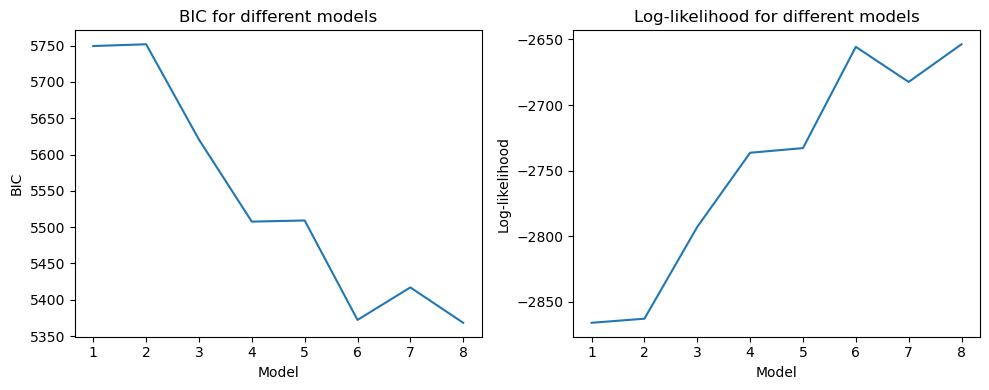

In [78]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))

axs[0].plot(bic_results.ModelIndex, bic_results.BIC)
axs[0].set_xlabel("Model")
axs[0].set_ylabel("BIC")
axs[0].set_title("BIC for different models")

axs[1].plot(bic_results.ModelIndex, bic_results.l)
axs[1].set_xlabel("Model")
axs[1].set_ylabel("Log-likelihood")
axs[1].set_title("Log-likelihood for different models")

fig.tight_layout()
plt.show()

**TODO: ANSWER**

## Part 6

Compare the fitted $\epsilon_{app}$ and $\epsilon_{wth}$ for the last model. How do you interpret the difference in their means?

In [156]:
last = model_fits[-1]

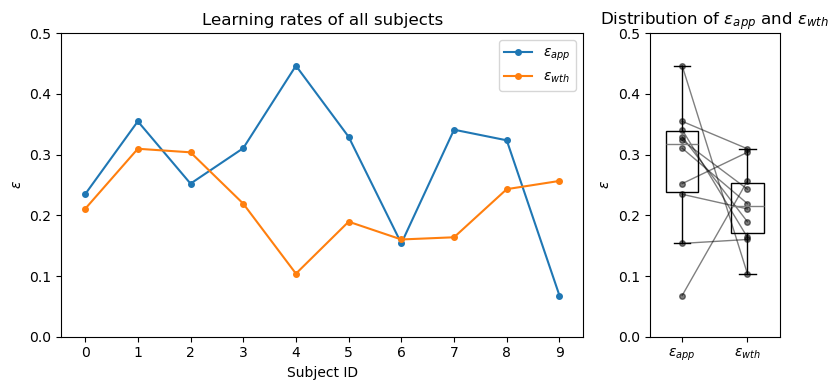

In [159]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (8, 4), width_ratios = [0.8, 0.2])

axs[0].plot(last.ID, last.epsilon_app, label = r"$\epsilon_{app}$", marker = "o", markersize = 4)
axs[0].plot(last.ID, last.epsilon_wth, label = r"$\epsilon_{wth}$", marker = "o", markersize = 4)
axs[0].set_ylabel(r"$\epsilon$")
axs[0].set_xlabel("Subject ID")
axs[0].set_xticks(last.ID)
axs[0].legend()
axs[0].set_title("Learning rates of all subjects")
axs[0].set_ylim(0, 0.5)

## Boxplot

epsilons = np.vstack([last.epsilon_app, last.epsilon_wth]).T

axs[1].boxplot(
    epsilons,
    patch_artist = True,
    widths = 0.5,
    boxprops = dict(facecolor = "white", color = "black"),
    medianprops = dict(color = "gray"),
    showfliers = False
)

x_positions = [1, 2]
for pair in epsilons:
    axs[1].plot(
        x_positions,
        pair,
        color = "black",
        marker = "o",
        alpha = 0.5,
        linewidth = 1,
        markersize = 4
    )

axs[1].set_xticks(x_positions)
axs[1].set_xticklabels([r"$\epsilon_{app}$", r"$\epsilon_{wth}$"])
axs[1].set_ylabel(r"$\epsilon$")
axs[1].set_title(r"Distribution of $\epsilon_{app}$ and $\epsilon_{wth}$")
axs[1].set_ylim(0, 0.5)

fig.tight_layout()
plt.show()

**TODO: ANSWER**

## Part 7

Bonus: Fit the first subject 10 times with the last model, using different initial parameters. Create a scatter plot between the fitted $bias_{app}$ and $bias_{wth}$ across the fits. How do you explain this plot?